In [49]:
#%matplotlib widget

import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import HbXConcentrations as hbx
import json
import auxFuncs as aux
from scipy.ndimage import median_filter

In [50]:
# Load sample Phantom experiments

# Attenuation maps
reconCC2_660 = np.loadtxt("ClinicalCase2_660nm_Med.dat")
reconCC2_830 = np.loadtxt("ClinicalCase2_830nm_Med.dat")

shapeReconPhantom1 = np.shape(reconCC2_660)
shapeReconPhantom2 = np.shape(reconCC2_830)

# Reconstruction data
with open("ClinicalCase2_660nm_reconData.json") as json_file:
    reconData = json.load(json_file)

# Center positions and shape
centersShape = reconData['centersShape']
centersPos = np.fromfile("ClinicalCase2_660nm_centers.bin", dtype=np.int16).reshape(centersShape)

In [51]:
sigmaGauss = 12
fftStrength = 0
maxDev = 3
doTotMap = False
doSatMap = True
colorMap = "Spectral_r"

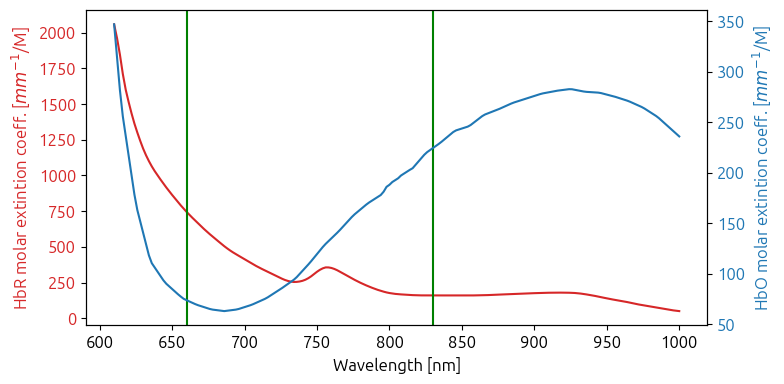

In [52]:
lambdas = [660, 830]

spectraHbR = "hbr.dat"
spectraHbO = "hbo.dat"

concHbO = 1 #g/ml
concHbR = 1 #g/ml

spectraArrayHbR = np.loadtxt(spectraHbR)
spectraArrayHbO = np.loadtxt(spectraHbO)



font = {'family': 'ubuntu',
        'weight': 'regular',
        'size': 12}

plt.rc('font', **font)

fig, ax1 = plt.subplots(figsize=(8, 4))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('HbR molar extintion coeff. [$mm^{-1}$/M]', color=color)
ax1.plot(spectraArrayHbR[:, 0][180:], aux.movingAverage(spectraArrayHbR[:, 1][180:],5) / concHbR, color=color, label="HbR")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Relative absorption', color=color)  # we already handled the x-label with ax1
ax2.plot(spectraArrayHbO[:, 0][180:], spectraArrayHbO[:, 1][180:] / concHbO, color=color, label="HbO")
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_xlabel("Wavelength [nm]")
ax2.set_ylabel("HbO molar extintion coeff. [$mm^{-1}$/M]")

fig.tight_layout()  # otherwise the right y-label is slightly clipped



for l in lambdas:
    ax1.axvline(x=l, color='green')


plt.savefig("HbSpectra.png", bbox_inches='tight', dpi=300)


In [53]:
imRaw = np.zeros((np.shape(reconCC2_660)[0], np.shape(reconCC2_660)[1], 2))
imRaw[:,:,0] = reconCC2_660
imRaw[:,:,1] = reconCC2_830

cropSize = 250

HbXMaps_2D = hbx.MamoRef_dHbX(imRaw, lambdas, centersPos, cropSize, cropSize, spectraData1 = spectraHbR, spectraData2 = spectraHbO, 
                              concentration1=concHbR, concentration2=concHbO, ua=0.002)
    
desOxyMap_CC2_2D = HbXMaps_2D[:,:,0]
OxyMap_CC2_2D = HbXMaps_2D[:,:,1]
TotMap_CC2_2D = desOxyMap_CC2_2D + OxyMap_CC2_2D

Step 1/2...


100%|██████████| 250/250 [00:40<00:00,  6.24it/s]


Step 2/2...


100%|██████████| 86/86 [07:06<00:00,  4.96s/it]
/home/nicolas/Bionirs/MamoRefCodePublic/HbXConcentrations.py:162: RuntimeWarning: invalid value encountered in divide
  LL = LL/cont


In [54]:
# Flip to match real positions

desOxyMap_CC2_2D = np.flip(desOxyMap_CC2_2D, axis=1)
OxyMap_CC2_2D = np.flip(OxyMap_CC2_2D, axis=1)
TotMap_CC2_2D = np.flip(TotMap_CC2_2D, axis=1)


#desOxyMap_CC2_2D_filtered = ndimage.median_filter(desOxyMap_CC2_2D,10)
#OxyMap_CC2_2D_filtered = ndimage.median_filter(OxyMap_CC2_2D,10)

#desOxyMap_CC2_2D_filtered = aux.fftGauss(desOxyMap_CC2_2D,5)[0]
#OxyMap_CC2_2D_filtered = aux.fftGauss(OxyMap_CC2_2D,5)[0]

desOxyMap_CC2_2D_filtered = desOxyMap_CC2_2D
OxyMap_CC2_2D_filtered = OxyMap_CC2_2D

desOxyMap_CC2_2D_filtered[np.isnan(desOxyMap_CC2_2D_filtered)] = 0
OxyMap_CC2_2D_filtered[np.isnan(OxyMap_CC2_2D_filtered)] = 0

np.savetxt("desOxyMap_CC2.dat", desOxyMap_CC2_2D_filtered)
np.savetxt("OxyMap_CC2.dat", OxyMap_CC2_2D_filtered)

In [55]:
#interestPositions = [[200, 300], [300, 350]]
interestPositions = []

interestSaturations = []

o2FFTFilter = 5
basalLevelHbO = np.min(OxyMap_CC2_2D_filtered)
basalLevelHbR = np.min(desOxyMap_CC2_2D_filtered)

for i in interestPositions:
    iSat = O2Sat(OxyMap_CC2_2D_filtered[i[0], i[1]]+basalLevelHbO, desOxyMap_CC2_2D_filtered[i[0], i[1]]+basalLevelHbR)
    interestSaturations.append(int(iSat))
    print("Oxygen saturation in {},{} is {}%".format(i[1], i[0], iSat))


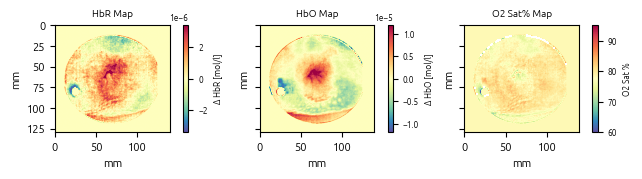

In [58]:
colorMap = "Spectral_r"
    
font = {'family' : 'ubuntu',
        'weight' : 'regular',
        'size'   : 8}

mp.rc('font', **font)

scale = 3.77
extent = [0, int(np.shape(desOxyMap_CC2_2D_filtered)[1]/scale), int(np.shape(desOxyMap_CC2_2D_filtered)[0]/scale), 0]

#incPosition = (342/scale, 224/scale)
#incRadius = 15


if doTotMap or doSatMap:
        figSats, ((DesOxy, Oxy, Tot)) = plt.subplots(1, 3, sharex=True, sharey=True)
        font["size"] = 6
        mp.rc('font', **font)
else:
        figSats, ((DesOxy, Oxy)) = plt.subplots(1, 2, sharex=True, sharey=True)        

maxDev = 4   


sd = np.nanstd(desOxyMap_CC2_2D_filtered)
median = np.nanmedian(desOxyMap_CC2_2D_filtered)
vmax = median + maxDev * sd
vmin = median - maxDev * sd

figDesOxy = DesOxy.imshow(desOxyMap_CC2_2D_filtered, cmap=mp.colormaps[colorMap], vmax = vmax, vmin = vmin, extent=extent)
#circle = patches.Circle(incPosition, radius=incRadius, edgecolor='black', facecolor='none')
#DesOxy.add_patch(circle)

for i in range(len(interestPositions)):
    DesOxy.scatter(interestPositions[i][1]/scale,
                   interestPositions[i][0]/scale, marker="x", c="green")
    DesOxy.annotate(str(interestSaturations[i]), xy=(interestPositions[i][1]/scale,
                    interestPositions[i][0]/scale), xytext=(10,10), textcoords="offset pixels" )


DesOxy.set_xlabel("mm")
DesOxy.set_ylabel("mm")
c1 = figSats.colorbar(figDesOxy, ax=DesOxy, fraction=0.04, pad=0.1)
c1.set_label("Δ HbR [mol/l]")


sd = np.nanstd(OxyMap_CC2_2D_filtered)
median = np.nanmedian(OxyMap_CC2_2D_filtered)
vmax = median + maxDev * sd
vmin = median - maxDev * sd


figOxy = Oxy.imshow(OxyMap_CC2_2D_filtered, cmap=mp.colormaps[colorMap], vmax = vmax, vmin = vmin, extent=extent)
#circle = patches.Circle(incPosition, radius=incRadius, edgecolor='black', facecolor='none')
#Oxy.add_patch(circle)

for i in range(len(interestPositions)):
    Oxy.scatter(interestPositions[i][1]/scale,
                interestPositions[i][0]/scale, marker="x", c="green")
    Oxy.annotate(str(interestSaturations[i]), xy=(interestPositions[i][1]/scale,
                    interestPositions[i][0]/scale), xytext=(10,10), textcoords="offset pixels" )


c2 = figSats.colorbar(figOxy, ax=Oxy, fraction=0.04, pad=0.1)
c2.set_label("Δ HbO [mol/l]")
Oxy.set_xlabel("mm")
Oxy.set_ylabel("mm")

if doTotMap:
        TotMap_CC2_2D = desOxyMap_CC2_2D_filtered + OxyMap_CC2_2D_filtered

        sd = np.nanstd(TotMap_CC2_2D)
        median = np.nanmedian(TotMap_CC2_2D)
        vmax = median + maxDev * sd
        vmin = median - maxDev * sd

        figTot = Tot.imshow(TotMap_CC2_2D, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
        #circle = patches.Circle(incPosition, radius=incRadius, edgecolor='black', facecolor='none')
        #Tot.add_patch(circle)
        
        for i in range(len(interestPositions)):
                Tot.scatter(interestPositions[i][1]/scale,
                    interestPositions[i][0]/scale, marker="x", c="green")
                Tot.annotate(str(interestSaturations[i]), xy=(interestPositions[i][1]/scale,
                    interestPositions[i][0]/scale), xytext=(10,10), textcoords="offset pixels" )
        
        c3 = figSats.colorbar(figTot, ax=Tot, fraction=0.04, pad=0.1)
        c3.set_label("Δ HbTot [mol/l]")
        Tot.set_xlabel("mm")
        Tot.set_ylabel("mm")

DesOxy.set_title("HbR Map")

Oxy.set_title("HbO Map")

if doSatMap:
    TotMap_CC2_2D = (OxyMap_CC2_2D_filtered+np.min(OxyMap_CC2_2D_filtered))/(OxyMap_CC2_2D_filtered +
                                                                             np.min(OxyMap_CC2_2D_filtered) + (desOxyMap_CC2_2D_filtered+np.min(desOxyMap_CC2_2D_filtered)))*100
    TotMap_CC2_2D[TotMap_CC2_2D>100]=np.nan

    sd = np.nanstd(TotMap_CC2_2D)
    median = np.nanmedian(TotMap_CC2_2D)
    vmax = median + maxDev * sd
    vmin = median - maxDev * sd

    figTot = Tot.imshow(TotMap_CC2_2D, vmin=60, vmax=95,
                        cmap=mp.colormaps[colorMap], extent=extent)
    
    for i in range(len(interestPositions)):
        Tot.scatter(interestPositions[i][1]/scale,
                    interestPositions[i][0]/scale, marker="x", c="green")
        Tot.annotate(str(interestSaturations[i]), xy=(interestPositions[i][1]/scale,
                                                      interestPositions[i][0]/scale), xytext=(10, 10), textcoords="offset pixels")

    c3 = figSats.colorbar(figTot, ax=Tot, fraction=0.04, pad=0.1)
    c3.set_label("O2 Sat %")
    Tot.set_xlabel("mm")
    Tot.set_ylabel("mm")

if doTotMap:
        Tot.set_title("Total HB HBMap")

if doSatMap:
    Tot.set_title("O2 Sat% Map")

figSats.tight_layout()

figSats.savefig("CC2_HbMaps_withSat.png", bbox_inches='tight', dpi=300)

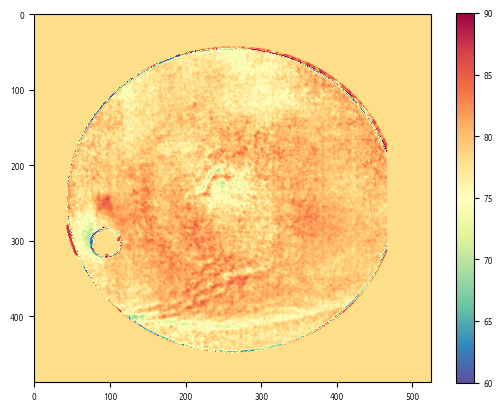

In [57]:
o2SatMap = (OxyMap_CC2_2D_filtered+np.min(OxyMap_CC2_2D_filtered))/(OxyMap_CC2_2D_filtered +
                                                                    np.min(OxyMap_CC2_2D_filtered) + (desOxyMap_CC2_2D_filtered+np.min(desOxyMap_CC2_2D_filtered)))*100

plt.imshow(o2SatMap, cmap=mp.colormaps[colorMap], vmin=60, vmax=90)
plt.colorbar()
